This notebook shows how to read from a "zarr" dataset, which has been "chunked" (broken into a little bits) in a way that makes grabbing a time series from a single point very quickly. 

The essence is that while the original data was many raster files, each file representing imagery from a single timestamp, the "zarr" dataset is stored in time series, so there is a single file for each pixel and all the values in time belonging to that pixel (actually, the files are 3x3 pixels).

In [33]:
import xarray as xr
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client, LocalCluster


### Start a Dask Cluster 

In [2]:
# Create a Dask cluster so we can watch the dask dashboard
workers = 6
ip_addres = 'http://j-lundquist-3.ce.washington.edu'
port=':8787'
threads = 2
cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
client = Client(cluster)

### Get the datetimes from the file names
because zarr has a bug that does not allow it to save `datetime64[ns]` objects correctly (precision is lost for hours and minutes)

In [5]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*_o.nc"))
datetimes = [
    dt.datetime.strptime(
        # Get the end time when the satellite finished scanning the picture
        f.split('/')[-1].split('_')[4][1:-3],
        "%Y%j%H%M%S"
    ) for f in files
]
# The files are not sorted chronologically, so we 
datetimes = sorted(datetimes)

[datetime.datetime(2022, 5, 1, 0, 0, 3),
 datetime.datetime(2022, 5, 1, 0, 0, 8),
 datetime.datetime(2022, 5, 1, 0, 1, 3),
 datetime.datetime(2022, 5, 1, 0, 1, 8),
 datetime.datetime(2022, 5, 1, 0, 2, 3),
 datetime.datetime(2022, 5, 1, 0, 2, 8),
 datetime.datetime(2022, 5, 1, 0, 3, 3),
 datetime.datetime(2022, 5, 1, 0, 3, 8),
 datetime.datetime(2022, 5, 1, 0, 4, 3),
 datetime.datetime(2022, 5, 1, 0, 4, 8),
 datetime.datetime(2022, 5, 1, 0, 5, 3),
 datetime.datetime(2022, 5, 1, 0, 5, 8),
 datetime.datetime(2022, 5, 1, 1, 0, 3),
 datetime.datetime(2022, 5, 1, 1, 0, 8),
 datetime.datetime(2022, 5, 1, 1, 1, 3),
 datetime.datetime(2022, 5, 1, 1, 1, 8),
 datetime.datetime(2022, 5, 1, 1, 2, 3),
 datetime.datetime(2022, 5, 1, 1, 2, 8),
 datetime.datetime(2022, 5, 1, 1, 3, 3),
 datetime.datetime(2022, 5, 1, 1, 3, 8),
 datetime.datetime(2022, 5, 1, 1, 4, 3),
 datetime.datetime(2022, 5, 1, 1, 4, 8),
 datetime.datetime(2022, 5, 1, 1, 5, 3),
 datetime.datetime(2022, 5, 1, 1, 5, 8),
 datetime.dateti

### Open the zarr dataset and replace the time index 

In [18]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    # chunks={'time': 40785, 'latitude': 3, 'longitude': 3},
    chunks={'time': 40785, 'latitude': 10, 'longitude': 10},
    engine='zarr'
)
ds['time'] = datetimes


/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Let's look at the time series at a single point, for 6 days

In [6]:
series = ds['HT'].sel(latitude = 48.509018, longitude = -123.035467, method='nearest')

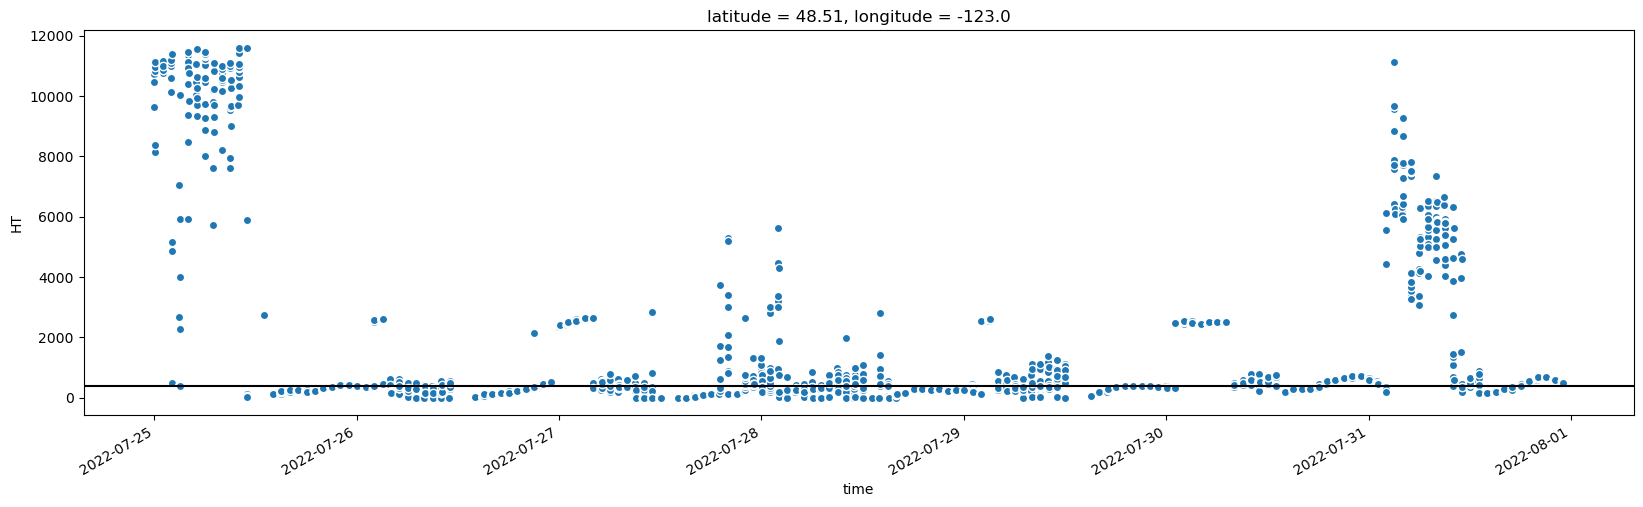

In [7]:
plt.figure(figsize = (20,5))
series.sel(time = slice('July 25, 2022', 'July 31, 2022')).plot.scatter('time')
plt.axhline(400, color='k')

In [7]:
pt1 = [48.50891,        -123.03491]
pt2 = [48.55745,        -123.0824]
pt3 = [48.52329,        -123.1371]
pt4 = [40.55423,        -122.36151]
pt5 = [48.46446,        -122.96222]
pt6 = [48.53304291, 	-123.0882645]
pt7 = [48.61820602, 	-123.1203384]
pt8 = [48.56717682, 	-123.1648407]
pt9 = [48.48910141, 	-123.0627441]
pt10 = [48.48910141, 	-123.0627441]
pt11 = [48.490756, 	    -123.067895]
pt12 = [48.57880161, 	-123.1731671]

### Calculate a fog frequency map

In [23]:
ds['FLCC'] = (ds['HT'] < 400).astype(int)

In [39]:
# documentation about indexing using datetime components: https://docs.xarray.dev/en/stable/user-guide/time-series.html#indexing-using-datetime-components
morning_ds = ds.isel(time=ds.time.dt.hour.isin([5,6,7,8,9]))
morning_ds

<xarray.Dataset>
Dimensions:      (time: 7209, latitude: 284, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude    (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time         (time) datetime64[ns] 2022-05-01T05:00:03 ... 2022-09-30T09:...
Data variables:
    HT           (time, latitude, longitude) float32 dask.array<chunksize=(7209, 10, 10), meta=np.ndarray>
    spatial_ref  (time) int64 dask.array<chunksize=(7209,), meta=np.ndarray>
    FLCC         (time, latitude, longitude) int64 dask.array<chunksize=(7209, 10, 10), meta=np.ndarray>

In [ ]:
midday_ds = ds.isel(time=ds.time.dt.hour.isin([11,12]))
afternoon_ds = ds.isel(time=ds.time.dt.hour.isin([1,2,3,4,5]))

### We call load to get this in memory right away - then plotting doesn't take a long time.

In [24]:
FLCC_freq = (
    ds['FLCC'].sum(dim='time') / ds['time'].size
)
FLCC_freq

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
dask.array<truediv, shape=(284, 284), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

In [25]:
FLCC_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
array([[5.46769646e-03, 5.46769646e-03, 5.46769646e-03, ...,
        1.47112909e-04, 1.47112909e-04, 1.47112909e-04],
       [5.46769646e-03, 5.46769646e-03, 5.46769646e-03, ...,
        1.47112909e-04, 1.47112909e-04, 1.47112909e-04],
       [5.46769646e-03, 5.46769646e-03, 5.46769646e-03, ...,
        1.47112909e-04, 1.47112909e-04, 1.47112909e-04],
       ...,
       [1.39855339e-01, 1.39855339e-01, 1.39855339e-01, ...,
        7.35564546e-05, 7.35564546e-05, 7.35564546e-05],
       [1.39855339e-01, 1.39855339e-01, 1.39855339e-01, ...,
        7.35564546e-05, 7.35564546e-05, 7.35564546e-05],
       [1.39855339e-01, 1.39855339e-01, 1.39855339e-01, ...,
        7.35564546e-05, 7.35564546e-05, 7.35564546e-05]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

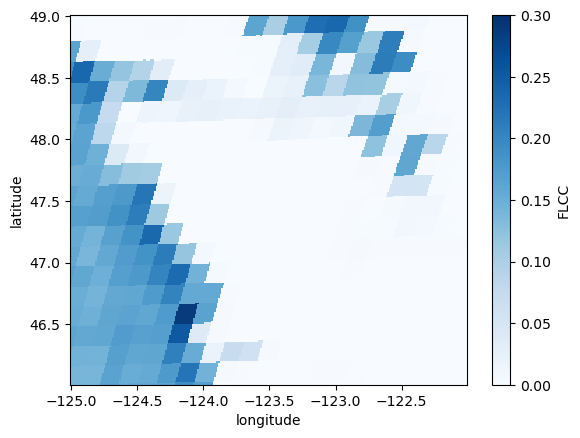

In [26]:
FLCC_freq.plot(cmap = 'Blues', vmin=0.0, vmax=0.3)

In [40]:
morning_freq = (
    morning_ds['FLCC'].sum(dim='time') / morning_ds['time'].size
)

In [ ]:
morning_freq.load()

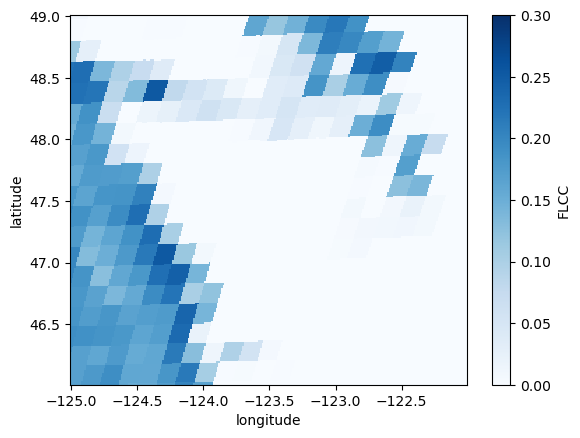

In [45]:
morning_freq.plot(cmap = 'Blues', vmin=0.0, vmax=0.3)